#### Preamble

In [ ]:
# Takes some time 3-5 minutes
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
findspark.init()

# Predicting Diabetes with PySpark
## EDA

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("diabetes").getOrCreate()

In [ ]:
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

In [ ]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 2 rows



In [ ]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [ ]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [ ]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

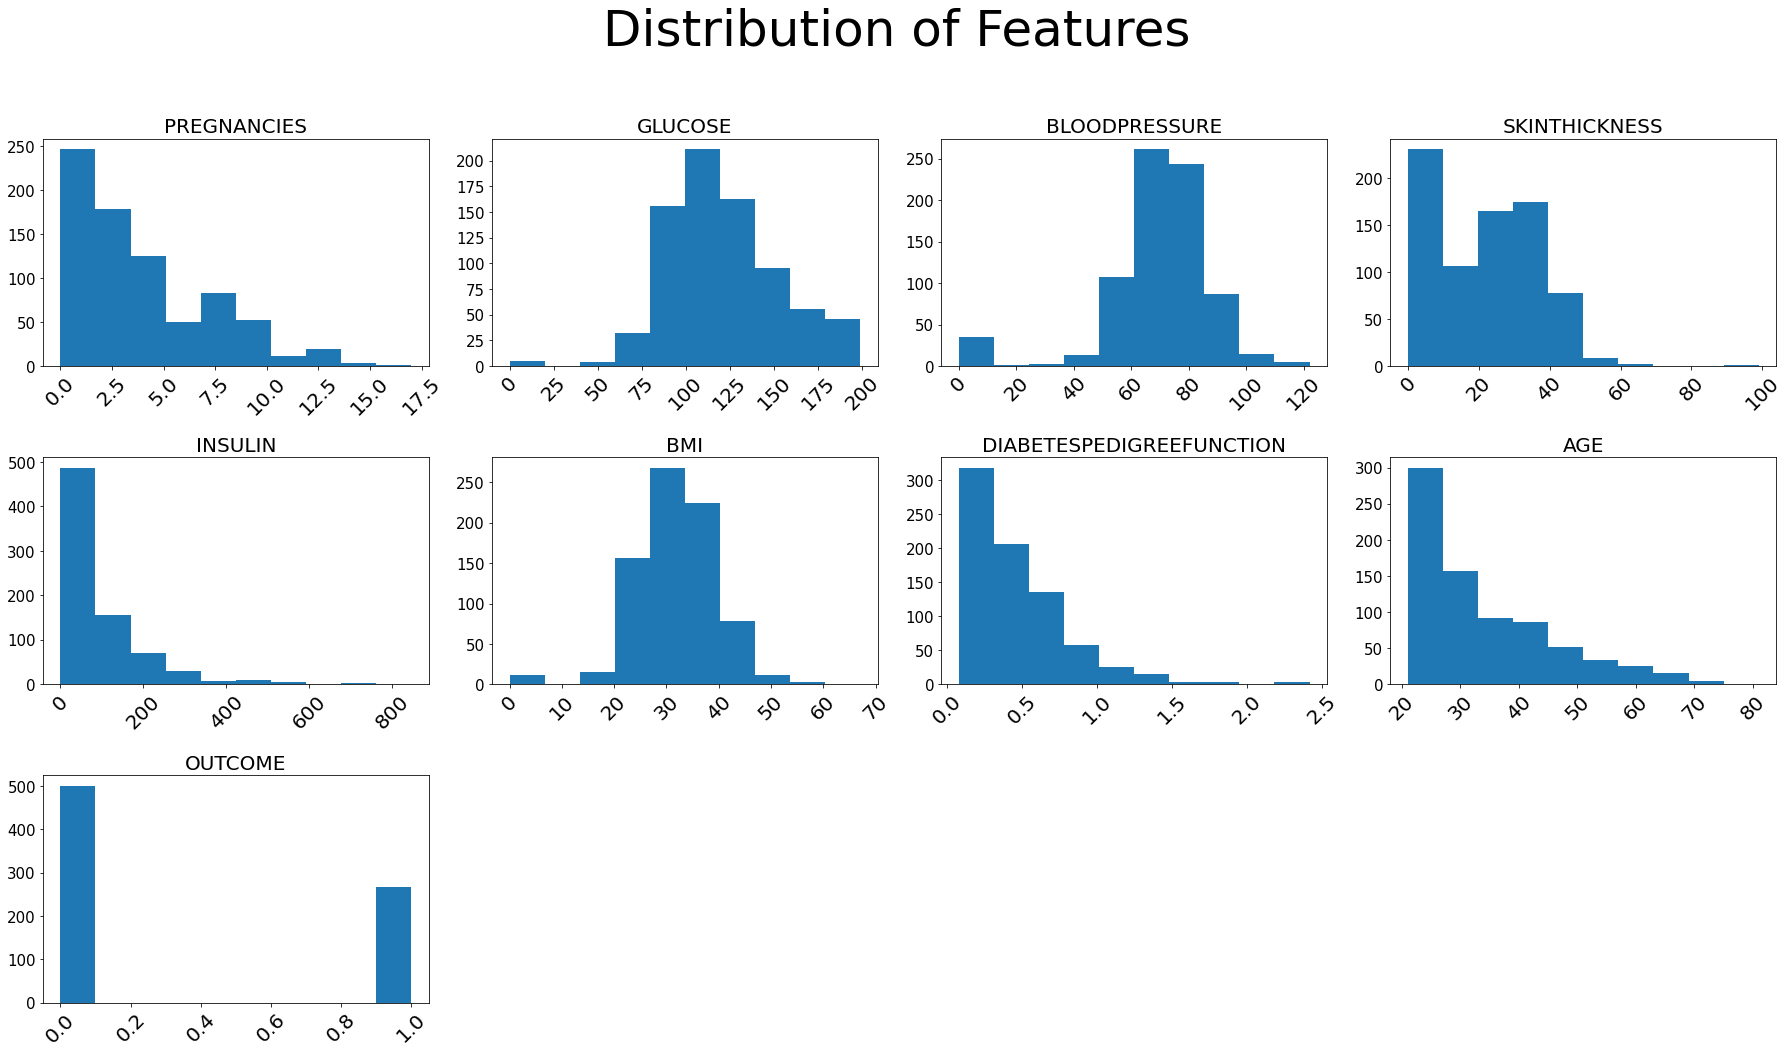

In [ ]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

In [ ]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


### User Defined Functions (UDF)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())

In [ ]:
df = df.withColumn("HasDiabetes",y_udf('Outcome')).drop("Outcome")

In [ ]:
df.show(3)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 3 rows



In [ ]:
def udf_multi(age):
  if (age < 25):
    return "Under 25"
  elif (age >=25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else: return "NA"

In [ ]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf', age_udf('Age'))

In [ ]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
only showing top 2 rows



In [ ]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import rank, sum, desc 
from pyspark.sql import Window

In [ ]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [ ]:
age_group_tab = df.select(["age_udf","Glucose"]).\
                      groupBy('age_udf').\
                          agg(
                              F.count('Glucose').alias('UserCount'),
                              F.mean('Glucose').alias('Glucose_AVG'),
                              F.min('Glucose').alias('Glucose_MIN'),
                              F.max('Glucose').alias('Glucose_MAX')).\
                          withColumn('total', sum(col('UserCount')).over(window)).\
                          withColumn('Percent', col('UserCount')*100 / col('total')).\
                          drop(col('total')).sort(desc('Percent'))

In [ ]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_AVG,Glucose_MIN,Glucose_MAX,Percent
0,Between 25 and 35,279,119.677419,68,198,36.328125
1,Under 25,219,110.858447,0,199,28.515625
2,Between 36 and 50,181,125.740331,0,197,23.567708
3,Over 50,89,139.550562,57,197,11.588542


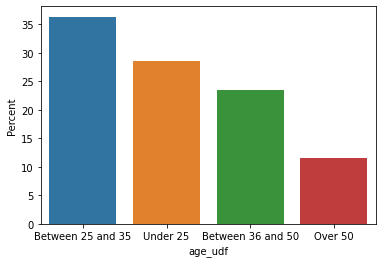

In [ ]:
sns.barplot(x="age_udf", y="Percent",data=age_group_tab.toPandas());

## Correlation

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [ ]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [ ]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


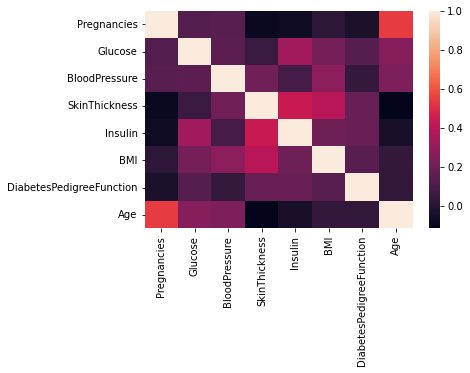

In [ ]:
sns.heatmap(corr_df);